# Emotion prediction using deep neural network (DNN) with weight sparsity control scheme

An artificial neural network with multiple hidden layers (known as a deep neural network, or DNN) was employed as a predictive model (DNNp) to predict emotional responses using whole-brain functional magnetic resonance imaging (fMRI) data from individual subjects. During fMRI data acquisition, 10 healthy participants listened to 80 International Affective Digital Sound stimuli and rated their own emotions generated by each sound stimulus in terms of the arousal, dominance, and valence dimensions. The whole-brain spatial patterns from a general linear model (i.e., beta-valued maps) for each sound stimulus and the emotional response ratings were used as the input and output for the DNNP, respectively.

## Import libraries

In [0]:
# -*- coding: utf-8 -*-

# This import statement gives Python access to all of TensorFlow's classes, methods, and symbols. 
import tensorflow as tf
# The fundamental package for scientific computing with Python.
import numpy as np
# Linear algebra module for calculating L1 and L2 norm  
from numpy import linalg as LA
# To plot the results
import matplotlib.pyplot as plt
# To check the directory when saving the results
import os.path
# The module for file input and output
import scipy.io as sio
# To measure time
import timeit
# To get date information
import datetime
# To get hsp combination
import itertools

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Input data

In [0]:
save_path = '/content/drive/My Drive/Colab_Notebooks/KHBM2019_MVPA/Regression_of_fMRI_volume'
datasets = sio.loadmat('/content/drive/My Drive/Colab_Notebooks/KHBM2019_MVPA/Regression_of_fMRI_volume/emt_valence_sample_zscore.mat')

############# emt_sample_data.mat #############
# train_x  = 64 volumes x 55417 voxels  
# train_y  = 64 volumes x 1 [valence scores for training]
# test_x  = 16 volumes x 55417 voxels
# test_y  = 16 volumes x 1 [valence scores for test]
############################################################

# the scale for the emotion response 
scale_ref = 10;

train_x = datasets['train_x']
train_y = datasets['train_y']/scale_ref

test_x = datasets['test_x']
test_y = datasets['test_y']/scale_ref

n_train_sample = train_y.shape[0];
n_test_sample = test_y.shape[0];

##  Define a regression model

<!DOCTYPE html>
<html>

<head>
    <meta charset="utf-8" />
    <meta http-equiv="X-UA-Compatible" content="IE=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1">
</head>

<body>
    <img src="https://drive.google.com/uc?export=view&id=1JQyvx2DjHOx30UfLyp6Lsqv6iLmj5Lfu">
</body>

</html>

In [0]:
"""
To create input, output and a MLP network  
"""

def init_model(n_nodes, layer_activation):
    
    if layer_activation=='sigmoid':
        layer_activation = tf.nn.sigmoid
    elif layer_activation=='tanh':
        layer_activation = tf.nn.tanh
    elif layer_activation=='relu':
        layer_activation = tf.nn.relu


    # 'node_index' to split placeholder, for example, given hidden_nodes=[100, 100, 100], nodes_index=[0, 100, 200, 300]
    nodes_index = [int(np.sum(n_nodes[1:i+1])) for i in range(np.size(n_nodes,axis=0)-1)]

    # Make two placeholders to fill the values later when training or testing
    X = tf.placeholder(tf.float32,[None,n_nodes[0]])
    # Y = tf.placeholder(tf.float32,[None,n_nodes[-1]])
    Y = tf.placeholder(tf.float32,[None,n_nodes[-1]])

    # Create randomly initialized weight variables
    # w_init = [tf.div(tf.random_normal([n_nodes[i],n_nodes[i+1]]), tf.sqrt(float(n_nodes[i])/2)) for i in range(np.size(n_nodes,axis=0)-1)]
    w_init=[tf.random_uniform([n_nodes[i],n_nodes[i+1]], -1*tf.sqrt(6./(n_nodes[i]+n_nodes[i+1])),tf.sqrt(6./(n_nodes[i]+n_nodes[i+1]))) for i in np.arange(np.shape(n_nodes)[0]-1)]
    w = [tf.Variable(w_init[i], dtype=tf.float32) for i in range(np.size(n_nodes,axis=0)-1)]
    # Create zero initialized bias variables
    # b = [tf.Variable(tf.zeros([n_nodes[i+1]]), dtype=tf.float32) for i in range(np.size(n_nodes,axis=0)-1)]
    b=[tf.Variable(tf.zeros([n_nodes[i+1]]), dtype=tf.float32) for i in np.arange(np.shape(n_nodes)[0]-1)]
  

    # Build an MLP model
    mlp_layers=[0.0]*(np.size(n_nodes,axis=0)-1)
    for i in range(np.size(n_nodes,axis=0)-1):
        # Input layer
        if i==0:
            mlp_layers[i] = tf.add(tf.matmul(X,w[i]),b[i])
            mlp_layers[i] = layer_activation(mlp_layers[i])
        # Hidden layers
        elif i>0 and i<(np.size(n_nodes,axis=0)-1):
            mlp_layers[i] = tf.add(tf.matmul(mlp_layers[i-1],w[i]),b[i])
            mlp_layers[i] = layer_activation(mlp_layers[i])
        # Output layer
        elif i==(np.size(n_nodes,axis=0)-1):
            mlp_layers[i] = tf.add(tf.matmul(mlp_layers[i-1],w[i]),b[i])


    return nodes_index, X, Y, mlp_layers, w, b

## Define training parameters

In [0]:
"""
L1 and L2 regularization terms

""" 

def init_regularizations(mode, n_nodes, nodes_index, n_tg_hsp, w, b):

    if mode=='layer':
        # The size is same with the number of layers
        Beta = tf.placeholder(tf.float32,[n_tg_hsp])
        # Get L1 loss term by simply multiplying beta(scalar value) and L1 norm of weight for each layer
        L1_loss = [tf.reduce_sum(tf.multiply(tf.abs(w[i]),Beta[i])) for i in range(n_tg_hsp)]

    elif mode=='node':
        # The size is same with the number of nodes
        Beta = tf.placeholder(tf.float32,[np.sum(n_nodes[1:(n_tg_hsp+1)])])
        # Get L1 loss term by multiplying beta(vector values as many as n_nodes) and L1 norm of weight for each layer
        L1_loss = [tf.reduce_sum(tf.matmul(tf.abs(w[i]),\
                                     tf.reshape(Beta[nodes_index[i]:nodes_index[i+1]],[-1,1]))) for i in range(n_tg_hsp)] 

    L1_loss_total = tf.reduce_sum(L1_loss)


    L2_REG = tf.placeholder(tf.float32)
    L2_loss = [tf.reduce_sum(tf.square(w[i])) for i in range(np.size(n_nodes,axis=0)-1)]
    L2_loss_total = tf.multiply(L2_REG,tf.reduce_sum(L2_loss))

    return Beta, L1_loss_total, L2_REG, L2_loss_total


""" 
Cost term (Cost = Mean sqaured error + L1 term + L2 term ) 
"""
def init_cost(mlp_layers, Y, L1_loss_total, L2_loss_total):

    # A softmax regression : it adds up the evidence of our input being in certain classes, and converts that evidence into probabilities.
    # cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=mlp_layers[-1], labels=Y)) \
    #                         + L1_loss_total + L2_loss_total
    
    # Mean squared error
    # cost = tf.losses.mean_squared_error(Y,mlp_layers[-1]) + L1_loss_total + L2_loss_total
    cost = tf.reduce_mean(tf.squared_difference(mlp_layers[-1], Y)) + L1_loss_total + L2_loss_total
    return cost
  

""" 
Error term  
"""
def init_error(mlp_layers, Y):

    # correct_prediction = tf.equal(tf.argmax(mlp_layers[-1],1),tf.argmax(Y,1))
    # error = 1-tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
    # error = tf.losses.mean_squared_error(Y,mlp_layers[-1])
    
    error = tf.reduce_mean(tf.squared_difference(mlp_layers[-1], Y)) 
    return error


"""
TensorFlow provides optimizers that slowly change each variable in order to minimize the loss function.
"""
def init_optimizer(optimizer_algorithm, cost, momentum):
    
    Lr = tf.placeholder(tf.float32)
    
    if optimizer_algorithm=='GradientDescent':
        optimizer = tf.train.GradientDescentOptimizer(Lr).minimize(cost)
    elif optimizer_algorithm=='Adagrad':
        optimizer = tf.train.AdagradOptimizer(Lr).minimize(cost)
    elif optimizer_algorithm=='Adam':
        optimizer = tf.train.AdamOptimizer(Lr).minimize(cost)
    elif optimizer_algorithm=='Momentum':
        optimizer = tf.train.MomentumOptimizer(Lr,momentum).minimize(cost)
    elif optimizer_algorithm=='RMSProp':
        optimizer = tf.train.RMSPropOptimizer(Lr).minimize(cost)

    return Lr, optimizer



"""
Variables to store training results
"""
def init_savingVariables(n_tg_hsp):
    if mode=='layer':
        beta_val = np.zeros(n_tg_hsp)
        beta_flat = np.zeros(n_tg_hsp)
        hsp_val = np.zeros(n_tg_hsp)
        result_beta = np.zeros(n_tg_hsp)
        result_hsp = np.zeros(n_tg_hsp)

    elif mode=='node':
        beta_val = [np.zeros(n_nodes[i+1]) for i in range(n_tg_hsp)]
        beta_flat = np.zeros(np.sum(n_nodes[1:-1]))
        hsp_val = [np.zeros(n_nodes[i+1]) for i in range(n_tg_hsp)]
        result_beta = [np.zeros(n_nodes[i+1]) for i in range(n_tg_hsp)]
        result_hsp = [np.zeros(n_nodes[i+1]) for i in range(n_tg_hsp)]


    # make arrays to store and plot results
    result_lr = np.zeros(1)
    result_cost = np.zeros(1)
    result_train_err = np.zeros(1)
    result_test_err = np.zeros(1)
    
    result_train_pct=np.zeros(n_train_sample)
    result_test_pct=np.zeros(n_test_sample)
 
   

    return beta_val, beta_flat, hsp_val, result_beta, result_hsp, result_lr, result_cost, result_train_err, result_test_err, result_train_pct, result_test_pct


## Define Hoyer's sparsity control function

![대체 텍스트](http://cfile211.uf.daum.net/image/99936D3C5D4BA942271035)

In [0]:
"""
Hoyer's sparsity level control
"""

def Hoyers_sparsity_control(mode, beta_lrates, W, b, max_b, tg):

    # Weight sparsity control with Hoyer's sparsness (Layer wise)
    if mode=='layer':

        # Get value of weight
        [n_nodes,dim]=W.shape
        num_elements=n_nodes*dim

        Wvec=W.flatten()

        # Calculate L1 and L2 norm
        L1=LA.norm(Wvec,1)
        L2=LA.norm(Wvec,2)

        # Calculate hoyer's sparsness
        h=(np.sqrt(num_elements)-(L1/L2))/(np.sqrt(num_elements)-1)

        # Update beta
        b-=beta_lrates*np.sign(h-tg)

        # Trim value
        b=0.0 if b<0.0 else b
        b=max_b if b>max_b else b

        return [h,b]

    # Weight sparsity control with Hoyer's sparsness (Node wise)
    elif mode=='node':

        b_vec = b

        # Get value of weight
        [n_nodes,dim]=W.shape

        # Calculate L1 and L2 norm
        L1=LA.norm(W,1,axis=0)
        L2=LA.norm(W,2,axis=0)

        h_vec = np.zeros((1,dim))
        tg_vec = np.ones(dim)*tg

        # Calculate hoyer's sparsness
        h_vec=(np.sqrt(n_nodes)-(L1/L2))/(np.sqrt(n_nodes)-1)

        # Update beta
        b_vec-=beta_lrates*np.sign(h_vec-tg_vec)

        # Trim value
        b_vec[b_vec<0.0]=0.0
        b_vec[b_vec>max_b]=max_b


        return [h_vec,b_vec]



## Set hyperparameters for training

In [0]:

""" 
Set the number of nodes for input, hidden layers and output layer
"""
n_nodes=[55417,20,20,20,1]



"""
Select optimizer :
    'GradientDescent'
    'Adagrad'
    'Adam'
    'Momentum'
    'RMSProp'
"""
optimizer_algorithm = 'Momentum'

momentum = 0.90


"""
Set learning hyperparameters
"""

# Total epochs
n_epochs = 500
# Mini batch size
batch_size = 2
# Initial learning rate
lr_init = 0.0005
# Learning rate anealing after **th epoch
begin_anneal = 100
# Learning rate decay rate
decay_rate = 0.00001
# Minimum learning rate
lr_min = 1e-6

# Layer activation 'sigmoid', 'tanh', 'relu'
layer_activation = 'tanh'

# Lambda for L2 regularization
L2_reg = 1e-8


"""
Select the sparsity control mode
'layer' for layer wise sparsity control
'node' for node wise sparsity control
"""

mode = 'node'

# Max beta
max_beta = [0.001, 0.03, 0.03]
# Beta learning rate
beta_lr = [1e-2, 1e-2, 1e-2]

# Candidates of target sparsness level for each layer (0:dense~1:sparse)
hsp_cands = list(itertools.product([0.3, 0.7],[0.3, 0.7],[0.3, 0.7])) #[[0.7, 0.7, 0.7]]
n_hsp_cands = len(hsp_cands)




"""
Set the directory to save results
"""
directory_path = save_path

# make a new 'results' directory in the current directory
dtime=datetime.datetime.now()
directory_save = os.path.join(directory_path, 'results_%04d%02d%02d_%02d%02d'%(dtime.year,dtime.month,dtime.day,dtime.hour,dtime.minute))
if not os.path.exists(directory_save):
    os.makedirs(directory_save)

## Create a model using definitions above

In [0]:
nodes_index, X, Y, mlp_layers, w, b = init_model(n_nodes, layer_activation)

Beta, L1_loss_total, L2_REG, L2_loss_total = init_regularizations(mode, n_nodes, nodes_index, len(hsp_cands[0]), w, b)
cost = init_cost(mlp_layers, Y, L1_loss_total, L2_loss_total)

error = init_error(mlp_layers, Y)

Lr, optimizer = init_optimizer(optimizer_algorithm, cost, momentum)

## Learning


 ****************************** Validation phase *******************************
# ( 1 / 8 ) hsp candidate : (0.3, 0.3, 0.3) #
< Epoch 50 > Cost : 6.443 / Train err : 0.064 /  Validation  err : 0.083
             beta : [0.001  0.0195 0.024 ] / hsp : [0.22253726 0.26217974 0.23202815]
< Epoch 100 > Cost : 0.791 / Train err : 0.066 /  Validation  err : 0.073
             beta : [0.     0.0045 0.0125] / hsp : [0.30179946 0.29956595 0.28150361]
< Epoch 150 > Cost : 0.072 / Train err : 0.070 /  Validation  err : 0.074
             beta : [0.    0.    0.002] / hsp : [0.30122738 0.3025225  0.30125474]
< Epoch 200 > Cost : 0.003 / Train err : 0.074 /  Validation  err : 0.077
             beta : [0.     0.0005 0.    ] / hsp : [0.30126125 0.30254065 0.3020799 ]
< Epoch 250 > Cost : 0.005 / Train err : 0.075 /  Validation  err : 0.074
             beta : [0.     0.     0.0005] / hsp : [0.301177   0.30263757 0.30205418]
< Epoch 300 > Cost : 0.000 / Train err : 0.077 /  Validation  err : 0.075
  

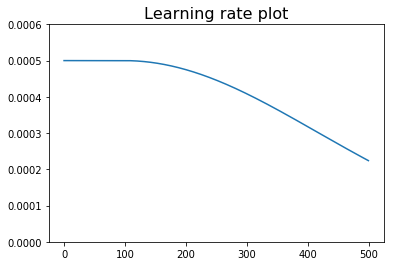

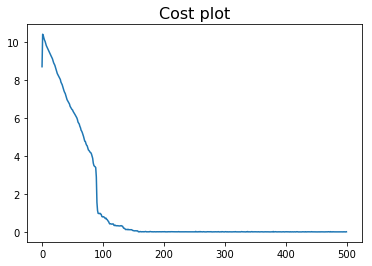

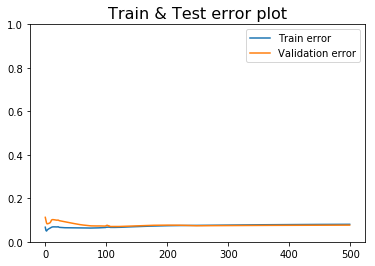

W0812 03:30:36.667975 139743047075712 legend.py:1289] No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

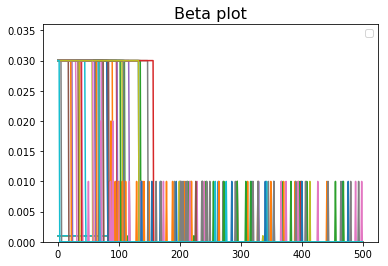

W0812 03:30:36.986515 139743047075712 legend.py:1289] No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

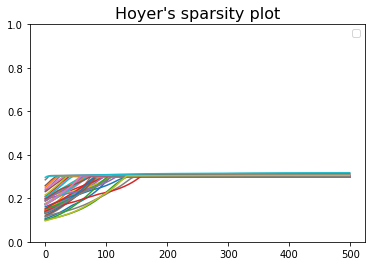


 ****************************** Validation phase *******************************
# ( 2 / 8 ) hsp candidate : (0.3, 0.3, 0.7) #
< Epoch 50 > Cost : 7.105 / Train err : 0.116 /  Validation  err : 0.218
             beta : [0.001  0.0255 0.03  ] / hsp : [0.22136476 0.23096756 0.26446538]
< Epoch 100 > Cost : 1.753 / Train err : 0.095 /  Validation  err : 0.171
             beta : [0.     0.0135 0.03  ] / hsp : [0.30164467 0.28459385 0.36000477]
< Epoch 150 > Cost : 0.690 / Train err : 0.076 /  Validation  err : 0.119
             beta : [0.   0.   0.03] / hsp : [0.30084715 0.30142557 0.47252282]
< Epoch 200 > Cost : 0.369 / Train err : 0.068 /  Validation  err : 0.093
             beta : [0.     0.0005 0.026 ] / hsp : [0.30067241 0.30115362 0.5805799 ]
< Epoch 250 > Cost : 0.132 / Train err : 0.068 /  Validation  err : 0.083
             beta : [0.     0.     0.0135] / hsp : [0.30068722 0.30159896 0.67304083]
< Epoch 300 > Cost : 0.041 / Train err : 0.068 /  Validation  err : 0.077
     

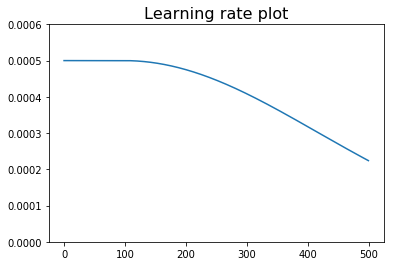

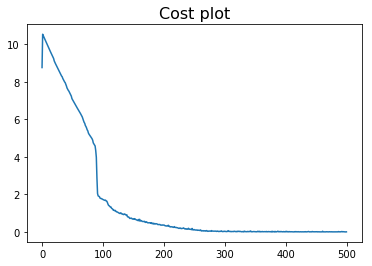

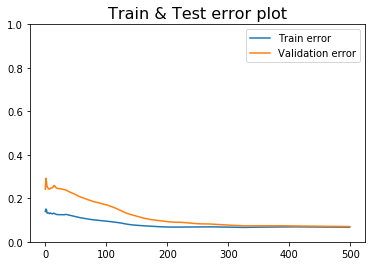

W0812 03:31:47.399735 139743047075712 legend.py:1289] No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

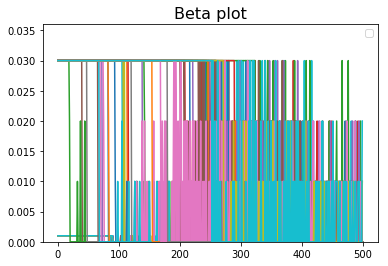

W0812 03:31:47.740038 139743047075712 legend.py:1289] No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

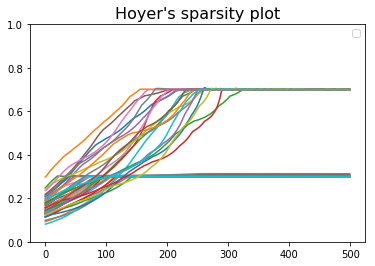


 ****************************** Validation phase *******************************
# ( 3 / 8 ) hsp candidate : (0.3, 0.7, 0.3) #
< Epoch 50 > Cost : 6.974 / Train err : 0.051 /  Validation  err : 0.042
             beta : [0.001  0.03   0.0235] / hsp : [0.22213113 0.25507535 0.24790024]
< Epoch 100 > Cost : 1.490 / Train err : 0.056 /  Validation  err : 0.038
             beta : [0.     0.03   0.0065] / hsp : [0.30190054 0.35069205 0.29330224]
< Epoch 150 > Cost : 0.762 / Train err : 0.058 /  Validation  err : 0.040
             beta : [0.     0.03   0.0005] / hsp : [0.3013212  0.44682273 0.30183312]
< Epoch 200 > Cost : 0.434 / Train err : 0.055 /  Validation  err : 0.037
             beta : [0.    0.028 0.   ] / hsp : [0.30104776 0.55528376 0.30171029]
< Epoch 250 > Cost : 0.152 / Train err : 0.050 /  Validation  err : 0.033
             beta : [0.     0.0185 0.    ] / hsp : [0.30092265 0.65399049 0.30161276]
< Epoch 300 > Cost : 0.034 / Train err : 0.050 /  Validation  err : 0.031
  

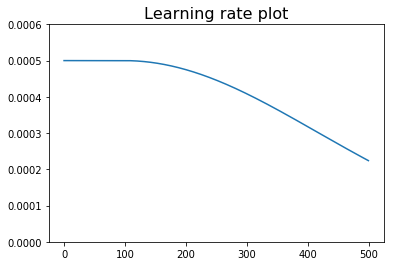

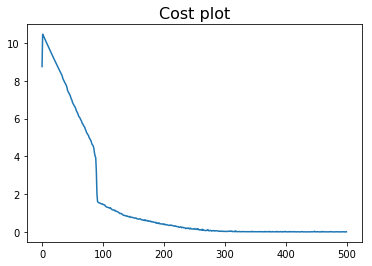

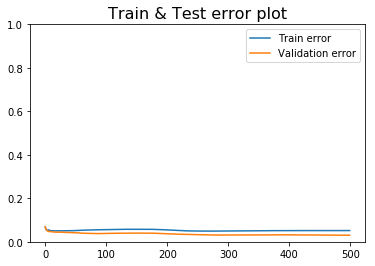

W0812 03:32:58.283025 139743047075712 legend.py:1289] No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

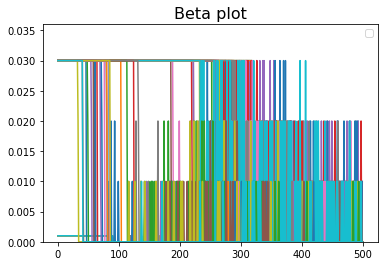

W0812 03:32:58.628810 139743047075712 legend.py:1289] No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

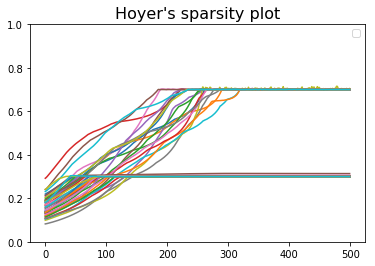


 ****************************** Validation phase *******************************
# ( 4 / 8 ) hsp candidate : (0.3, 0.7, 0.7) #
< Epoch 50 > Cost : 7.118 / Train err : 0.066 /  Validation  err : 0.046
             beta : [0.001 0.03  0.03 ] / hsp : [0.22284004 0.27308043 0.26314742]
< Epoch 100 > Cost : 2.147 / Train err : 0.062 /  Validation  err : 0.029
             beta : [0.   0.03 0.03] / hsp : [0.30184991 0.37322868 0.38584609]
< Epoch 150 > Cost : 1.301 / Train err : 0.054 /  Validation  err : 0.029
             beta : [0.   0.03 0.03] / hsp : [0.30146024 0.48089531 0.49923854]
< Epoch 200 > Cost : 0.614 / Train err : 0.044 /  Validation  err : 0.026
             beta : [0.    0.024 0.025] / hsp : [0.30130711 0.60740749 0.60930096]
< Epoch 250 > Cost : 0.194 / Train err : 0.039 /  Validation  err : 0.024
             beta : [0.    0.011 0.009] / hsp : [0.30123767 0.67016116 0.68658718]
< Epoch 300 > Cost : 0.061 / Train err : 0.041 /  Validation  err : 0.025
             beta : 

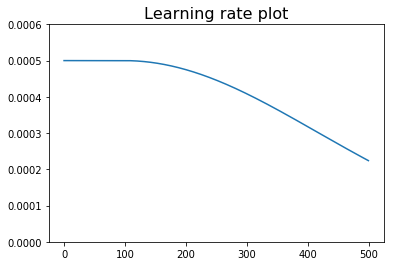

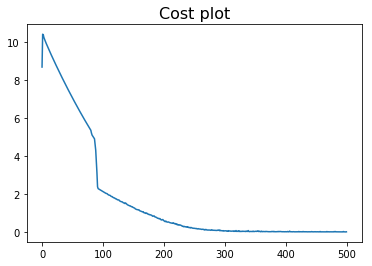

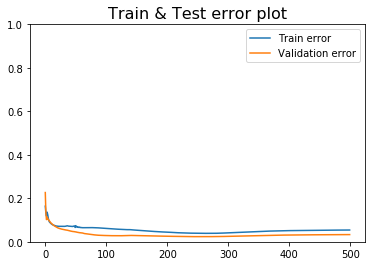

W0812 03:34:08.962270 139743047075712 legend.py:1289] No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

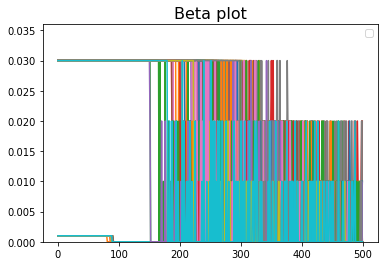

W0812 03:34:09.519187 139743047075712 legend.py:1289] No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

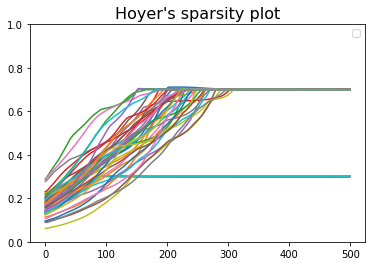


 ****************************** Validation phase *******************************
# ( 5 / 8 ) hsp candidate : (0.7, 0.3, 0.3) #
< Epoch 50 > Cost : 6.546 / Train err : 0.072 /  Validation  err : 0.079
             beta : [0.001  0.0255 0.0195] / hsp : [0.22065608 0.23397044 0.24978737]
< Epoch 100 > Cost : 3.185 / Train err : 0.075 /  Validation  err : 0.097
             beta : [0.001  0.0105 0.009 ] / hsp : [0.31969645 0.27811294 0.27861393]
< Epoch 150 > Cost : 1.237 / Train err : 0.079 /  Validation  err : 0.104
             beta : [0.001  0.0045 0.0005] / hsp : [0.43548848 0.29841302 0.30153155]
< Epoch 200 > Cost : 0.351 / Train err : 0.068 /  Validation  err : 0.056
             beta : [0.001 0.    0.   ] / hsp : [0.57826989 0.30225944 0.30170936]
< Epoch 250 > Cost : 0.002 / Train err : 0.066 /  Validation  err : 0.056
             beta : [0. 0. 0.] / hsp : [0.70434094 0.30222138 0.3015912 ]
< Epoch 300 > Cost : 0.000 / Train err : 0.070 /  Validation  err : 0.056
             b

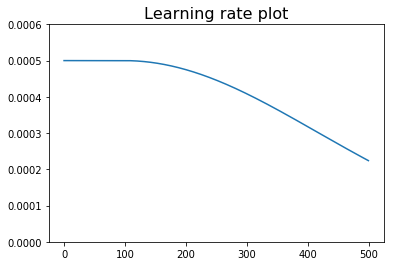

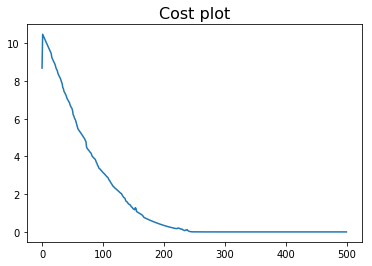

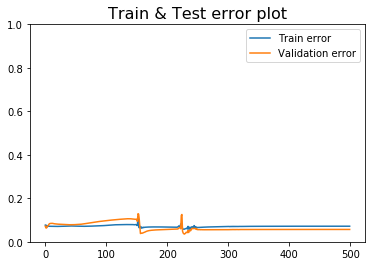

W0812 03:35:19.379733 139743047075712 legend.py:1289] No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

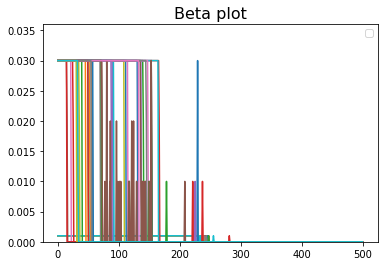

W0812 03:35:19.687937 139743047075712 legend.py:1289] No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

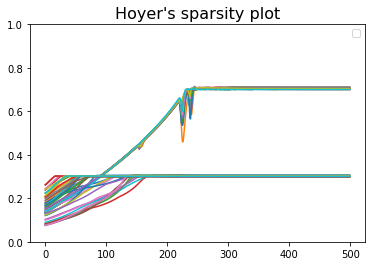


 ****************************** Validation phase *******************************
# ( 6 / 8 ) hsp candidate : (0.7, 0.3, 0.7) #
< Epoch 50 > Cost : 7.184 / Train err : 0.075 /  Validation  err : 0.058
             beta : [0.001 0.024 0.03 ] / hsp : [0.22098702 0.22838849 0.22643685]
< Epoch 100 > Cost : 4.011 / Train err : 0.067 /  Validation  err : 0.065
             beta : [0.001 0.012 0.03 ] / hsp : [0.32038139 0.28772746 0.3215762 ]
< Epoch 150 > Cost : 1.871 / Train err : 0.059 /  Validation  err : 0.059
             beta : [0.001  0.0015 0.03  ] / hsp : [0.43669502 0.30101886 0.42011254]
< Epoch 200 > Cost : 0.731 / Train err : 0.053 /  Validation  err : 0.055
             beta : [0.001  0.     0.0285] / hsp : [0.58110958 0.30081141 0.54704042]
< Epoch 250 > Cost : 0.123 / Train err : 0.053 /  Validation  err : 0.049
             beta : [5.00e-05 0.00e+00 1.25e-02] / hsp : [0.70114528 0.30045715 0.67066284]
< Epoch 300 > Cost : 0.024 / Train err : 0.055 /  Validation  err : 0.047

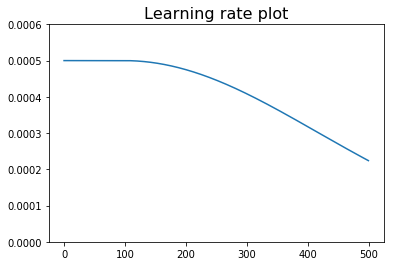

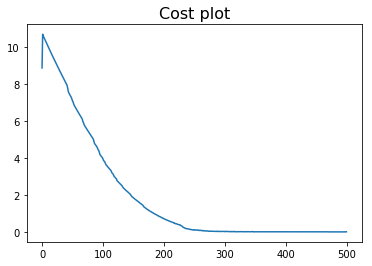

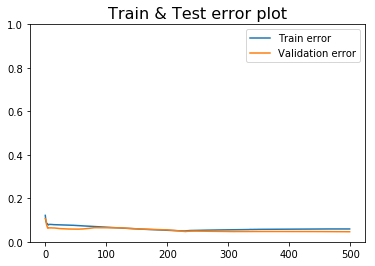

W0812 03:36:29.807285 139743047075712 legend.py:1289] No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

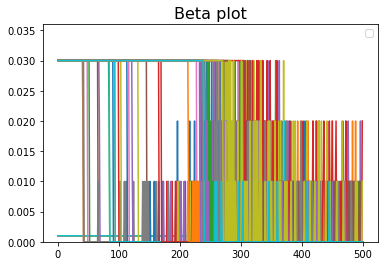

W0812 03:36:30.148292 139743047075712 legend.py:1289] No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

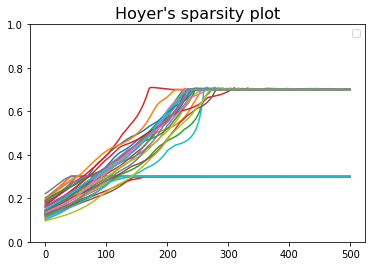


 ****************************** Validation phase *******************************
# ( 7 / 8 ) hsp candidate : (0.7, 0.7, 0.3) #
< Epoch 50 > Cost : 6.851 / Train err : 0.061 /  Validation  err : 0.033
             beta : [0.001  0.03   0.0195] / hsp : [0.22098641 0.23819589 0.25061346]
< Epoch 100 > Cost : 3.937 / Train err : 0.052 /  Validation  err : 0.030
             beta : [0.001 0.03  0.009] / hsp : [0.32024219 0.3257186  0.28654247]
< Epoch 150 > Cost : 1.948 / Train err : 0.048 /  Validation  err : 0.031
             beta : [0.001 0.03  0.002] / hsp : [0.43666125 0.41756412 0.2995487 ]
< Epoch 200 > Cost : 0.804 / Train err : 0.046 /  Validation  err : 0.034
             beta : [0.001  0.0285 0.0005] / hsp : [0.58115672 0.54132089 0.30019994]
< Epoch 250 > Cost : 0.143 / Train err : 0.047 /  Validation  err : 0.037
             beta : [5.0e-05 1.5e-02 1.0e-03] / hsp : [0.70074365 0.66056523 0.30020177]
< Epoch 300 > Cost : 0.033 / Train err : 0.052 /  Validation  err : 0.037
  

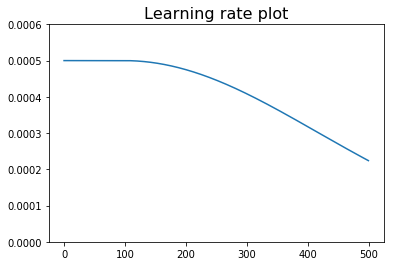

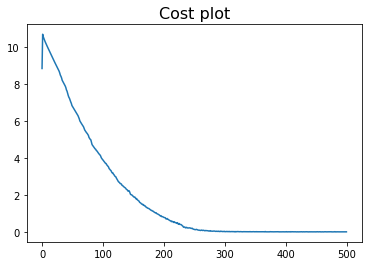

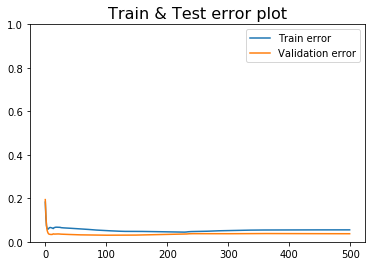

W0812 03:37:40.050064 139743047075712 legend.py:1289] No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

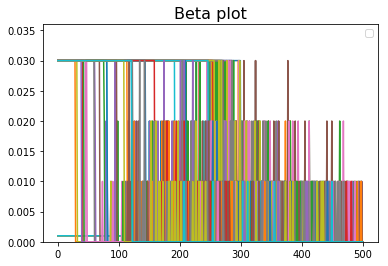

W0812 03:37:40.387221 139743047075712 legend.py:1289] No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

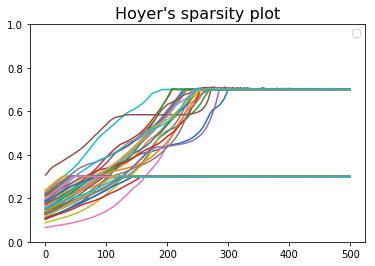


 ****************************** Validation phase *******************************
# ( 8 / 8 ) hsp candidate : (0.7, 0.7, 0.7) #
< Epoch 50 > Cost : 7.232 / Train err : 0.055 /  Validation  err : 0.124
             beta : [0.001 0.03  0.03 ] / hsp : [0.22206457 0.26217249 0.2595127 ]
< Epoch 100 > Cost : 4.525 / Train err : 0.049 /  Validation  err : 0.077
             beta : [0.001 0.03  0.03 ] / hsp : [0.32204069 0.36951561 0.35266406]
< Epoch 150 > Cost : 2.487 / Train err : 0.041 /  Validation  err : 0.039
             beta : [0.001 0.03  0.03 ] / hsp : [0.43950476 0.48366565 0.45577785]
< Epoch 200 > Cost : 1.082 / Train err : 0.036 /  Validation  err : 0.025
             beta : [0.001 0.024 0.027] / hsp : [0.58591976 0.58241847 0.57117315]
< Epoch 250 > Cost : 0.266 / Train err : 0.038 /  Validation  err : 0.025
             beta : [5.00e-05 1.85e-02 1.60e-02] / hsp : [0.70070877 0.66324466 0.66076885]
< Epoch 300 > Cost : 0.064 / Train err : 0.039 /  Validation  err : 0.025
     

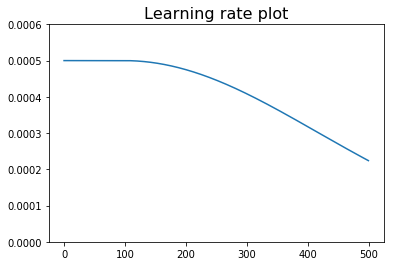

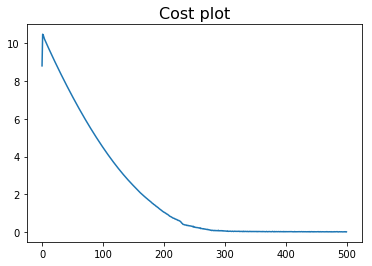

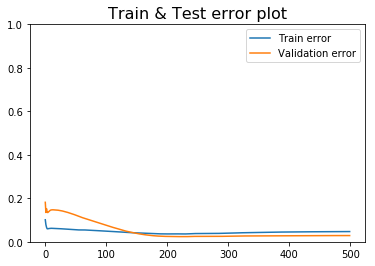

W0812 03:38:50.464152 139743047075712 legend.py:1289] No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

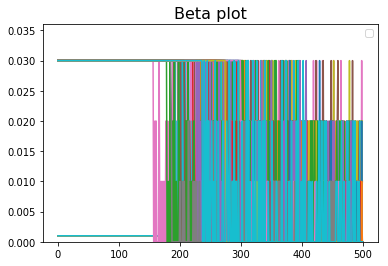

W0812 03:38:50.850200 139743047075712 legend.py:1289] No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

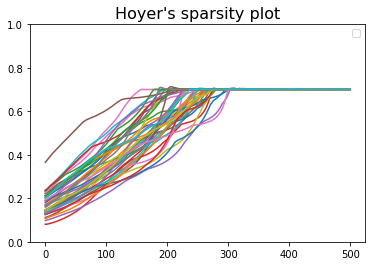


 ****************************** Test phase *******************************
############### ==> Selected hsp : (0.7, 0.7, 0.7) ###############
< Epoch 50 > Cost : 1.028 / Train err : 0.032 /  Test  err : 0.025
             beta : [0.001  0.027  0.0225] / hsp : [0.59172316 0.59329524 0.59315621]
< Epoch 100 > Cost : 0.030 / Train err : 0.041 /  Test  err : 0.035
             beta : [0.    0.    0.002] / hsp : [0.70167454 0.7011272  0.70068026]
< Epoch 150 > Cost : 0.012 / Train err : 0.048 /  Test  err : 0.044
             beta : [5.e-05 0.e+00 5.e-04] / hsp : [0.70219693 0.70072485 0.70044166]
< Epoch 200 > Cost : 0.008 / Train err : 0.049 /  Test  err : 0.049
             beta : [0.    0.    0.001] / hsp : [0.70196535 0.70079117 0.70052009]
< Epoch 250 > Cost : 0.010 / Train err : 0.051 /  Test  err : 0.054
             beta : [5.e-05 0.e+00 0.e+00] / hsp : [0.70184481 0.70087316 0.70044247]
< Epoch 300 > Cost : 0.003 / Train err : 0.052 /  Test  err : 0.050
             beta : [0.   

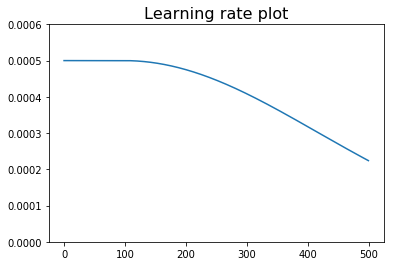

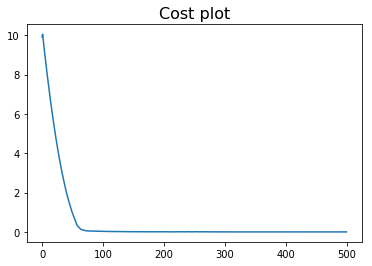

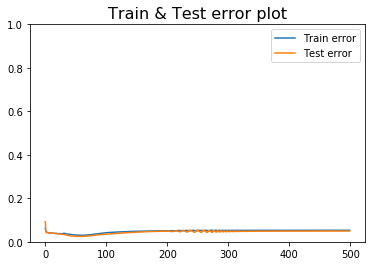

W0812 03:42:18.941853 139743047075712 legend.py:1289] No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

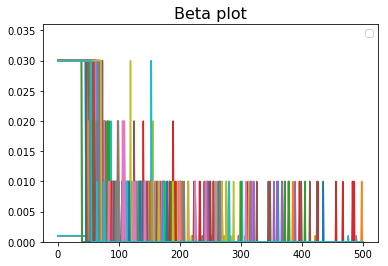

W0812 03:42:19.269323 139743047075712 legend.py:1289] No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

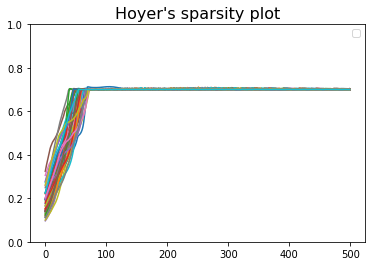

<Figure size 432x288 with 0 Axes>

In [9]:
start_time = timeit.default_timer()

error_vd = [None]*n_hsp_cands
hsp_vd = [None]*n_hsp_cands

for i_tg in range(n_hsp_cands+1):
    
        
    # If it is validation phase 
    if i_tg < n_hsp_cands:      
        vd_ts = 'Validation'
        # Target hsp
        hsp_tg = hsp_cands[i_tg]
        n_hsp_tg = len(hsp_tg)
        
        # First half
        train_x_set = train_x[:int(np.size(train_x,axis=0)/4)][:]
        train_y_set = train_y[:int(np.size(train_y,axis=0)/4)][:]
        # Secend half
        test_x_set = train_x[int(np.size(train_x,axis=0)/4):][:]
        test_y_set = train_y[int(np.size(train_y,axis=0)/4):][:]
        print("\n ****************************** Validation phase *******************************")
        print("# (",i_tg+1,"/",n_hsp_cands,") hsp candidate :",hsp_tg,"#")
        
    # If it is test phase
    else:
        vd_ts = 'Test'
        i_selected = np.argmin(error_vd)
        hsp_tg = hsp_cands[i_selected]
        n_hsp_tg = len(hsp_tg) 

        train_x_set = train_x[:][:]
        train_y_set = train_y[:][:]
        test_x_set = test_x[:][:]
        test_y_set = test_y[:][:]
        print("\n ****************************** Test phase *******************************")
        print("############### ==> Selected hsp :",hsp_tg,"###############")


        
        
    # Training starts    
    with tf.Session(config=tf.ConfigProto(log_device_placement=False)) as sess:
        
        # beta_val, beta_flat, hsp_val, result_beta, result_hsp, result_lr, result_cost, result_train_err, result_test_err = init_savingVariables(n_hsp_tg)
        beta_val, beta_flat, hsp_val, result_beta, result_hsp, result_lr, result_cost, result_train_err, result_test_err, result_train_pct, result_test_pct = init_savingVariables(n_hsp_tg) 

        
        # To initialize all the variables in a TensorFlow program, you must explicitly call a special operation
        init = tf.global_variables_initializer()

        # run tensorflow variable initialization
        sess.run(init)


        # Start training
        for epoch in range(n_epochs):

            # Shuffle training data at the begining of each epoch
            n_samples = np.size(train_x_set, axis=0)
            
            # Begin annealing
            if epoch == 0:
                lr = lr_init
            elif decay_rate!=0 and (epoch+1)>begin_anneal:
                lr = max( lr_min, (-decay_rate*(epoch+1) + (1+decay_rate*begin_anneal)) * lr )

            cost_epoch=0.0
            
            # How many mini-batch iterations we need
            n_batches = int(np.ceil(n_samples/batch_size))
            
            # minibatch based training
            for batch in range(n_batches):
                first_sample = batch*batch_size
                last_sample = min((batch+1)*batch_size, n_samples)
                batch_x = train_x_set[first_sample:last_sample]
                batch_y = train_y_set[first_sample:last_sample]
  
                # Get cost and optimize the model
                cost_batch,_ = sess.run([cost,optimizer],{Lr:lr, X:batch_x, Y:batch_y, Beta:beta_flat, L2_REG:L2_reg})
                cost_epoch += cost_batch/n_batches

                # Weight sparsity control
                if mode=='layer':
                    for i in range(n_hsp_tg):
                        [hsp_val[i], beta_val[i]] = Hoyers_sparsity_control(mode, beta_lr[i], sess.run(w[i]), beta_val[i], max_beta[i], hsp_tg[i])
                    beta_flat = beta_val[:]

                elif mode=='node':
                    for i in range(n_hsp_tg):
                        [hsp_val[i], beta_val[i]] = Hoyers_sparsity_control(mode, beta_lr[i], sess.run(w[i]), beta_val[i], max_beta[i], hsp_tg[i])
                    # flatten beta_val (shape (3, 100) -> (300,))
                    beta_flat = [item for sublist in beta_val for item in sublist]

            # get train and test error
            train_pct_epoch=sess.run(mlp_layers[-1],{X:train_x,Y:train_y});
            train_ref=sess.run(Y,{X:train_x,Y:train_y});
            train_err_epoch = (np.square(train_ref - train_pct_epoch.flatten())).mean()
            
            test_pct_epoch=sess.run(mlp_layers[-1],{X:test_x,Y:test_y});
            test_ref=sess.run(Y,{X:test_x,Y:test_y});
            test_err_epoch = (np.square(test_ref - test_pct_epoch.flatten())).mean()

            # Save the results to array
            result_train_err=np.hstack([result_train_err,[train_err_epoch]])
            result_train_pct =np.vstack([result_train_pct,[train_pct_epoch.flatten()]])
            result_test_err=np.hstack([result_test_err,[test_err_epoch]])
            result_test_pct=np.vstack([result_test_pct,[test_pct_epoch.flatten()]])
            
            result_lr = np.hstack([result_lr,[lr]])
            result_cost = np.hstack([result_cost,[cost_epoch]])

            if mode=='layer':
                result_hsp=[np.vstack([result_hsp[i],[hsp_val[i]]]) for i in range(n_hsp_tg)]
                result_beta=[np.vstack([result_beta[i],[beta_flat[i]]]) for i in range(n_hsp_tg)]

            elif mode=='node':
                result_hsp=[np.vstack([result_hsp[i],[np.transpose(hsp_val[i])]]) for i in range(n_hsp_tg)]
                result_beta=[np.vstack([result_beta[i],[np.transpose(beta_val[i])]]) for i in range(n_hsp_tg)]

            # Print result at epoch 
            if ((epoch+1)%50==0):
                print("< Epoch", "{:02d}".format(epoch+1),"> Cost :", "{:.3f}".format(cost_epoch)\
                                                ,"/ Train err :", "{:.3f}".format(train_err_epoch),"/ ",vd_ts," err :","{:.3f}".format(test_err_epoch))
                print("             beta :",np.mean(np.swapaxes(result_beta,0,1)[-1][:][:],axis=1),"/ hsp :",np.mean(np.swapaxes(result_hsp,0,1)[-1][:][:],axis=1))

                
        print("")
        print("-> Error :", "{:.3f}".format(result_test_err[-1]))
        
            
        # Plot and save the figures
        
        # Make a new results directory for the target
        hsp_tg_str=['0.%02d-'%(i*100) for i in hsp_tg]
        hsp_tg_str[-1]=hsp_tg_str[-1][:-1]
        hsp_tg_str=''.join(hsp_tg_str)

        directory_results = os.path.join(directory_save, r'%s_hsp_tg_%s'%(vd_ts,hsp_tg_str))
        if not os.path.exists(directory_results):
            os.makedirs(directory_results)


        # Plot the change of learning rate
        plt.figure()
        plt.title("Learning rate plot",fontsize=16)
        result_lr=result_lr[1:]
        plt.ylim(0.0, lr_init*1.2)
        plt.plot(result_lr)
        plt.savefig(directory_results+'/learning_rate.png')
        plt.show(block=False)


        # Plot the change of cost
        plt.figure()
        plt.title("Cost plot",fontsize=16)
        result_cost=result_cost[1:]
        plt.plot(result_cost)
        plt.savefig(directory_results+'/cost.png')
        plt.show(block=False)


        # Plot train & test error
        plt.figure()
        plt.title("Train & Test error plot",fontsize=16)
        result_train_err=result_train_err[1:]
        plt.plot(result_train_err, label='Train error')
        result_test_err=result_test_err[1:]
        plt.plot(result_test_err, label='%s error'%vd_ts)
        plt.ylim(0.0, 1.0)
        plt.legend(loc='upper right')
        plt.show(block=False)
        plt.savefig(directory_results+'/error_'+"tr{:.3f}_ts{:.3f}".format(result_train_err[-1],result_test_err[-1])+'.png')


        # Plot the change of beta value
        print("")
        plt.figure()
        for i in range(n_hsp_tg):
            print("")
            plt.title("Beta plot",fontsize=16)
            result_beta[i]=result_beta[i][1:]
            plt.plot(result_beta[i], label='layer%d'%(i+1) if mode=='layer' else '')
            plt.ylim(0.0, np.max(max_beta)*1.2)
        plt.legend(loc='best')
        plt.show(block=False)
        plt.savefig(directory_results+'/beta.png')


        # Plot the change of Hoyer's sparsity
        print("")
        plt.figure()
        for i in range(n_hsp_tg):
            print("")
            plt.title("Hoyer's sparsity plot",fontsize=16)
            result_hsp[i]=result_hsp[i][1:]
            plt.plot(result_hsp[i], label='layer%d'%(i+1) if mode=='layer' else '')
            plt.ylim(0.0, 1.0)
        plt.legend(loc='best')
        plt.show(block=False)
        if n_hsp_tg == 3:
            plt.savefig(directory_results + '/hsp_final_' + "{:.3f}".format(
                np.mean(result_hsp[0][-1])) + '_' + "{:.3f}".format(
                np.mean(result_hsp[1][-1])) + '_' + "{:.3f}".format(
                np.mean(result_hsp[2][-1])) + '.png')
        elif n_hsp_tg == 2:
            plt.savefig(directory_results + '/hsp_final_' + "{:.3f}".format(
                np.mean(result_hsp[0][-1])) + '_' + "{:.3f}".format(
                np.mean(result_hsp[1][-1])) + '.png')
        elif n_hsp_tg == 1:
            plt.savefig(directory_results + '/hsp_final_' + "{:.3f}".format(
                np.mean(result_hsp[0][-1])) + '.png')
            
            
        # save results as .mat file
        sio.savemat(directory_results+"/result_learningrate.mat", mdict={'lr': result_lr})
        sio.savemat(directory_results+"/result_cost.mat", mdict={'cost': result_cost})
        sio.savemat(directory_results+"/result_train_err.mat", mdict={'trainErr': result_train_err})
        sio.savemat(directory_results+"/result_test_err.mat", mdict={'testErr': result_test_err})
        sio.savemat(directory_results+"/result_beta.mat", mdict={'beta': result_beta})
        sio.savemat(directory_results+"/result_hsp.mat", mdict={'hsp': result_hsp})
        sio.savemat(directory_results+"/result_weight.mat", mdict={'weight': sess.run(w)})
        sio.savemat(directory_results+"/result_bias.mat", mdict={'bias': sess.run(b)})
        sio.savemat(directory_results+"/result_train_pct.mat", mdict={'trainPct': result_train_pct})
        sio.savemat(directory_results+"/result_test_pct.mat", mdict={'testPct': result_test_pct})
        sio.savemat(directory_results+"/result_train_ref.mat", mdict={'trainRef': train_ref})
        sio.savemat(directory_results+"/result_test_ref.mat", mdict={'testRef': test_ref})
        
        
        if i_tg < n_hsp_cands: 
            plt.close('all')
            error_vd[i_tg] = result_test_err[-1]
            hsp_vd[i_tg] = np.mean(np.swapaxes(result_hsp,0,1)[-1][:][:],axis=1)
            
            
        
end_time = timeit.default_timer()

# Save parameters and summary

In [0]:
f = open(directory_save+"/parameters_summary.txt",'w') 
f.write('mode : '+str(mode)+'\n')
f.write('optimizer_algorithm : '+str(optimizer_algorithm)+'\n')
f.write('layer_activation : '+str(layer_activation)+'\n')
f.write('n_epochs : '+str(n_epochs)+'\n')
f.write('batch_size : '+str(batch_size)+'\n')
f.write('lr_init : '+str(lr_init)+'\n')
f.write('lr_min : '+str(lr_min)+'\n')
f.write('begin_anneal : '+str(begin_anneal)+'\n')
f.write('decay_rate : '+str(decay_rate)+'\n')
f.write('L2_reg : '+str(L2_reg)+'\n')
f.write('max_beta : '+str(max_beta)+'\n')
f.write('beta_lr : '+str(beta_lr)+'\n')
f.write('---\n')
for i_tg in range(n_hsp_cands):
    f.write('('+str(i_tg+1)+'/'+str(n_hsp_cands)+') tg :'+str(hsp_cands[i_tg])+'/ hsp : '+str(hsp_vd[i_tg])+'- val error : '+"{:.3f}".format(error_vd[i_tg])+'\n')
f.write('==> Selected tg :'+str(hsp_cands[i_selected])+'/ hsp : '+str(np.mean(np.swapaxes(result_hsp,0,1)[-1][:][:],axis=1))+'- ts error : '+"{:.3f}".format(result_test_err[-1])+'\n')
f.write('\n The code ran for %d mins' %((end_time-start_time)/60)+'\n\n')
f.close()
